In [1]:
# note : predicted data point was actually from older observation
# note : for the old model, it predicts the phases from 6/25,7/1,8/16
# note : seems to also predict phases from recent observations

# code now converts HST day to corresponding UTC time
# 1) +1 day since we observe on next day at midnight
# 2) +10:00:00 to convert to UTC


In [2]:
import pickle
import numpy as np
from radvel.utils import t_to_phase
from astropy.time import Time
import matplotlib.pyplot as plt
import pandas as pd

with open('../MCMC_results/1PlanetLinearResults_LongerRun/1PlanetLinearResults_LongerRun_post_obj.pkl', 'rb') as f:
    post = pickle.load(f)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import rcParams, gridspec
from matplotlib import pyplot as pl
from matplotlib.ticker import MaxNLocator
from astropy.time import Time

import radvel
from radvel import plot
from radvel.plot import mcmc_plots
from radvel.plot import orbit_plots
from radvel.utils import t_to_phase, fastbin, sigfig


#RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot = orbit_plots.MultipanelPlot(post)
def plot_phasefold(self, pltletter, pnum):
        """
        Plot phased orbit plots for each planet in the fit.
        Args:
            pltletter (int): integer representation of 
                letter to be printed in the corner of the first
                phase plot.
                Ex: ord("a") gives 97, so the input should be 97.
            pnum (int): the number of the planet to be plotted. Must be
                the same as the number used to define a planet's 
                Parameter objects (e.g. 'per1' is for planet #1)
        """

        ax = pl.gca()

        if len(self.post.likelihood.x) < 20: 
            self.nobin = True

        bin_fac = 1.75
        bin_markersize = bin_fac * rcParams['lines.markersize']
        bin_markeredgewidth = bin_fac * rcParams['lines.markeredgewidth']

        rvmod2 = self.model(self.rvmodt, planet_num=pnum) - self.slope
        modph = t_to_phase(self.post.params, self.rvmodt, pnum, cat=True) - 1
        rvdat = self.rawresid + self.model(self.rvtimes, planet_num=pnum) - self.slope_low
        phase = t_to_phase(self.post.params, self.rvtimes, pnum, cat=True) - 1
        rvdatcat = np.concatenate((rvdat, rvdat))
        rverrcat = np.concatenate((self.rverr, self.rverr))
        rvmod2cat = np.concatenate((rvmod2, rvmod2))
        bint, bindat, binerr = fastbin(phase+1, rvdatcat, nbins=25)
        bint -= 1.0

        ax.axhline(0, color='0.5', linestyle='--', )
        ax.plot(sorted(modph), rvmod2cat[np.argsort(modph)], 'b-', linewidth=self.fit_linewidth)
        plot.labelfig(pltletter)

        telcat = np.concatenate((self.post.likelihood.telvec, self.post.likelihood.telvec))

        if self.highlight_last:
            ind = np.argmax(self.rvtimes)
            hphase = t_to_phase(self.post.params, self.rvtimes[ind], pnum, cat=False)
            if hphase > 0.5:
                hphase -= 1
            pl.plot(hphase, rvdatcat[ind], **plot.highlight_format)

#        plot.mtelplot(phase, rvdatcat, rverrcat, telcat, ax, telfmts=self.telfmts)
#        if not self.nobin and len(rvdat) > 10: 
#            ax.errorbar(
#                bint, bindat, yerr=binerr, fmt='ro', mec='w', ms=bin_markersize,
#                mew=bin_markeredgewidth
#            )

        if self.phase_limits:
            ax.set_xlim(self.phase_limits[0], self.phase_limits[1])
        else:
            ax.set_xlim(-2,2)
            #ax.set_xlim(-0.5, 0.5)

#        if not self.yscale_auto: 
#            scale = np.std(rvdatcat)
#            ax.set_ylim(-self.yscale_sigma*scale, self.yscale_sigma*scale)
        
        keys = [p+str(pnum) for p in ['per', 'k', 'e']]

        labels = [self.post.params.tex_labels().get(k, k) for k in keys]
        if pnum < self.num_planets:
            ticks = ax.yaxis.get_majorticklocs()
            ax.yaxis.set_ticks(ticks[1:-1])

        ax.set_ylabel('RV [{ms:}]'.format(**plot.latex), weight='bold')
        ax.set_xlabel('Phase', weight='bold')

        print_params = ['per', 'k', 'e']
        units = {'per': 'days', 'k': plot.latex['ms'], 'e': ''}

        anotext = []
        for l, p in enumerate(print_params):
            val = self.post.params["%s%d" % (print_params[l], pnum)].value
            
            if self.uparams is None:
                _anotext = r'$\mathregular{%s}$ = %4.2f %s' % (labels[l].replace("$", ""), val, units[p])
            else:
                if hasattr(self.post, 'medparams'):
                    val = self.post.medparams["%s%d" % (print_params[l], pnum)]
                else:
                    print("WARNING: medparams attribute not found in " +
                          "posterior object will annotate with " +
                          "max-likelihood values and reported uncertainties " +
                          "may not be appropriate.")
                err = self.uparams["%s%d" % (print_params[l], pnum)]
                if err > 1e-15:
                    val, err, errlow = sigfig(val, err)
                    _anotext = r'$\mathregular{%s}$ = %s $\mathregular{\pm}$ %s %s' \
                               % (labels[l].replace("$", ""), val, err, units[p])
                else:
                    _anotext = r'$\mathregular{%s}$ = %4.2f %s' % (labels[l].replace("$", ""), val, units[p])

            anotext += [_anotext]

In [4]:
obs_times_jd = np.array([])
obs_times_ymd = np.array([])
dates = open('keck_dates.txt').readlines()
dates = list(dict.fromkeys(dates))

for date in dates: 
    # extract date
    ds = date.split('-')
    day, month, year = ds[0], ds[1], ds[2][:-1]
    
    # convert HST to UTC
    obs_time_ymd = year+'-'+month+'-'+day+'T10:00:00' # +10:00:00 for UTC
    obs_time_jd = Time(obs_time_ymd, format='isot', scale='utc').jd + 1 # +1 for midnight on next day
    
    # store values
    obs_times_ymd = np.append(obs_times_ymd, obs_time_ymd)
    obs_times_jd = np.append(obs_times_jd, obs_time_jd)


phases  = t_to_phase(RVPlot.post.params, obs_times_jd, 1, cat=True) - 1
obs_times_jd_cat = np.concatenate((obs_times_jd, obs_times_jd))
obs_times_ymd_cat = np.concatenate((obs_times_ymd, obs_times_ymd))


0.08095837295756048 2020-09-24T10:00:00
0.1126253425767072 2020-09-25T10:00:00
0.14429231219585392 2020-09-26T10:00:00


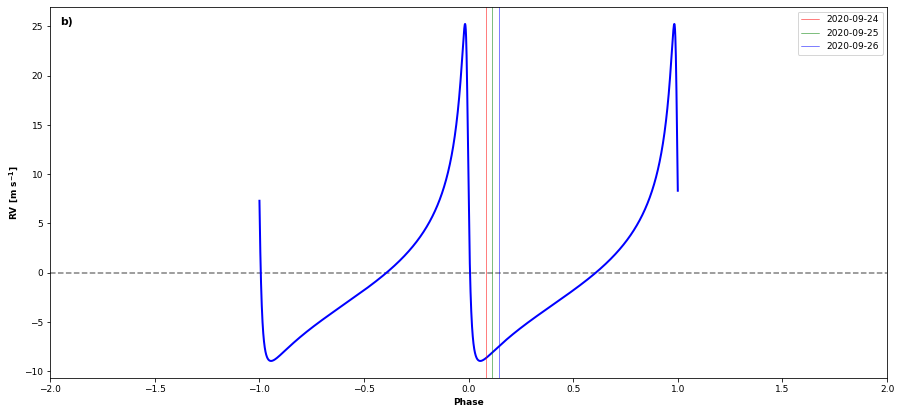

In [7]:
import random
plt.figure(figsize=(15,15))
plt.subplot(211)
plot_phasefold(RVPlot,ord('b'),1)

#for phase in phases:
#    plt.axvline(x=phase, linewidth=0.5,color='silver')


for i in range(len(phases)):
    phase_val = phases[i]
    time_val = obs_times_ymd_cat[i]
    if np.abs(phase_val) < 0.5:
        if '2020-09-24' in time_val:
            print(phase_val,time_val)
            plt.axvline(x=phase_val, linewidth=0.5,color='red',label='2020-09-24')
        elif '2020-09-25' in time_val:
            print(phase_val,time_val)
            plt.axvline(x=phase_val, linewidth=0.5,color='green',label='2020-09-25')
        elif '2020-09-26' in time_val:
            print(phase_val,time_val)
            plt.axvline(x=phase_val, linewidth=0.5,color='blue',label='2020-09-26')

#plt.xlim(-0.5,0.5)
plt.legend()